# Interpretable Machine Learning
## Exercise Sheet: 4
## This exercise sheet covers chapters 6, 8.1 + 8.2 from the IML book by Christoph Molnar

Kristin Blesch (blesch@leibniz-bips.de)<br>
Niklas Koenen (koenen@leibniz-bips.de)
<hr style="border:1.5px solid gray"> </hr>

# 1) Partial Dependence Plot (PDP)

In this task, the concept of Partial Dependence Plots (PDP) will be explained. For this, you have to train a multilayer perceptron (MLP) on the regression dataset `sklearn.datasets.fetch_california_housing` and then implement the PDP method on your own.

## a) Data
Load the data and get familiar with it by extracting the features $X$ as a `pandas.DataFrame` and the target $Y$. Then, answer the following questions:

- What are the features and what are their types (numeric, binary, categorical)?
- What is the target outcome?

**Solution:**

In [30]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()

In [31]:
features = data.data
target = data.target
h1 = pd.DataFrame(data = features, columns = data.feature_names)
h2 = pd.DataFrame(data = target, columns = data.target_names)
house = pd.concat([h1, h2], axis = 1)

In [32]:
display(house.head(8))

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414


In [33]:
house.dtypes

MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt


<Figure size 1008x684 with 0 Axes>

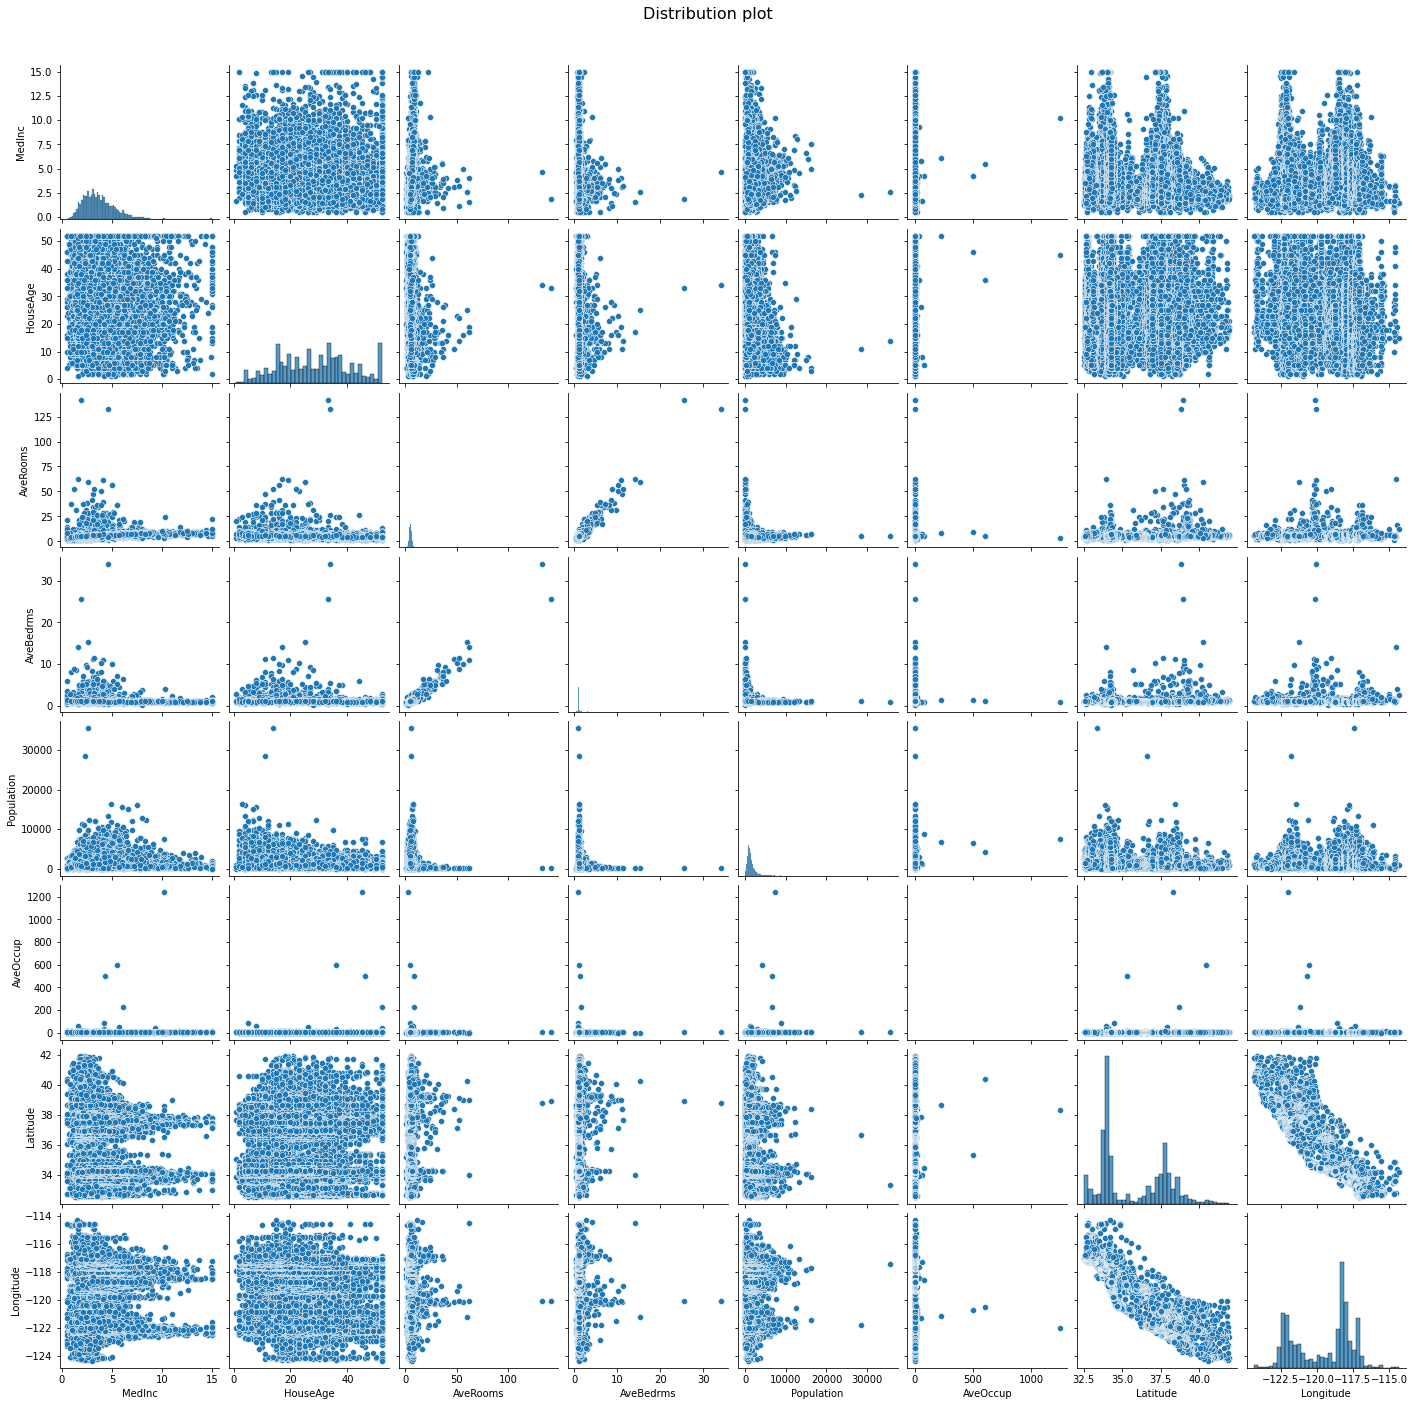

In [35]:
plt.figure(figsize = (14, 9.5))
sns.pairplot(data = h1)
plt.suptitle("Distribution plot", fontsize = 16)
plt.subplots_adjust(top = 0.94)


In [36]:
# Create train and test split
from sklearn.model_selection import train_test_split
rate = 0.2
x_train, x_test, y_train, y_test = train_test_split(h1, h2, test_size = rate)
print(f">>>> x_train_shape: {x_train.shape}, y_train_shape: {y_train.shape}\
\n>>>> x_test_shape: {x_test.shape}, y_test_shape: {y_test.shape}")

# Define model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

model =  make_pipeline(
    QuantileTransformer(),
    MLPRegressor(
        hidden_layer_sizes=(50, 50), learning_rate_init=0.01, early_stopping=True
    )
)

# Train the model on the trainings data

model.fit(x_train, y_train)

# Calculate the R^2- value
R_square = model.score(x_test, y_test)
print(f"\n>>>> The R_square value for mlp-reg is: {R_square*100:.2f} percent")

>>>> x_train_shape: (16512, 8), y_train_shape: (16512, 1)
>>>> x_test_shape: (4128, 8), y_test_shape: (4128, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



>>>> The R_square value for mlp-reg is: 77.42 percent


## c) Implement PDP
**i)** Now let's apply the method to the feature `HouseAge`. Crate a PDP for this feature.

**Hint:** Get the minimum and maximum value of this feature and create a vector with the intermediate values (`np.linspace(min, max, 100)`). Insert these values into the test data in a loop and calculate the average output. Finally, create a plot with `plt.plot`.

**Solution:**

Text(0, 0.5, 'prediction')

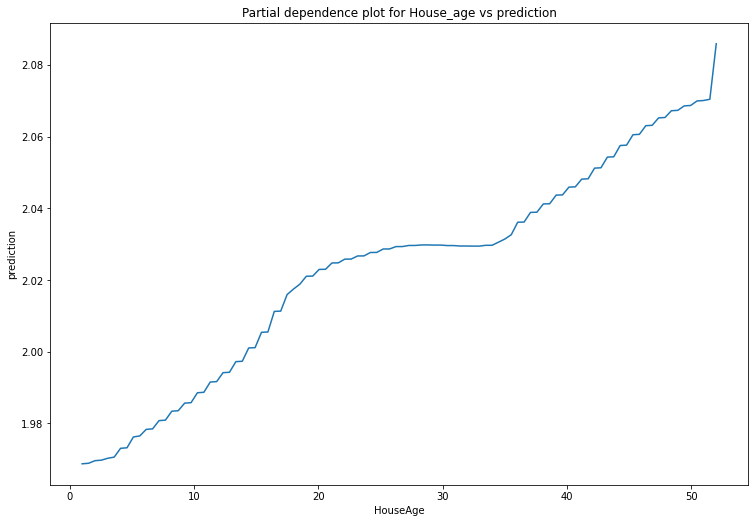

In [37]:
import numpy as np
import matplotlib.pyplot as plt

min = h1.HouseAge.min()
max = h1.HouseAge.max()
values = np.linspace(start = min, stop = max, num = 100)
dp_values = list()
for value in values:
  x_test['HouseAge'] = value
  dp_values.append(np.mean(model.predict(x_test)))

plt.figure(figsize = (12.5, 8.5))
plt.plot(values, dp_values)
plt.title("Partial dependence plot for House_age vs prediction")
plt.xlabel("HouseAge")
plt.ylabel("prediction")


**ii)** Create another PDP for this feature with the predefined function [`PartialDependenceDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.PartialDependenceDisplay.html#sklearn-inspection-partialdependencedisplay) and check your implementation.

**Solution:**

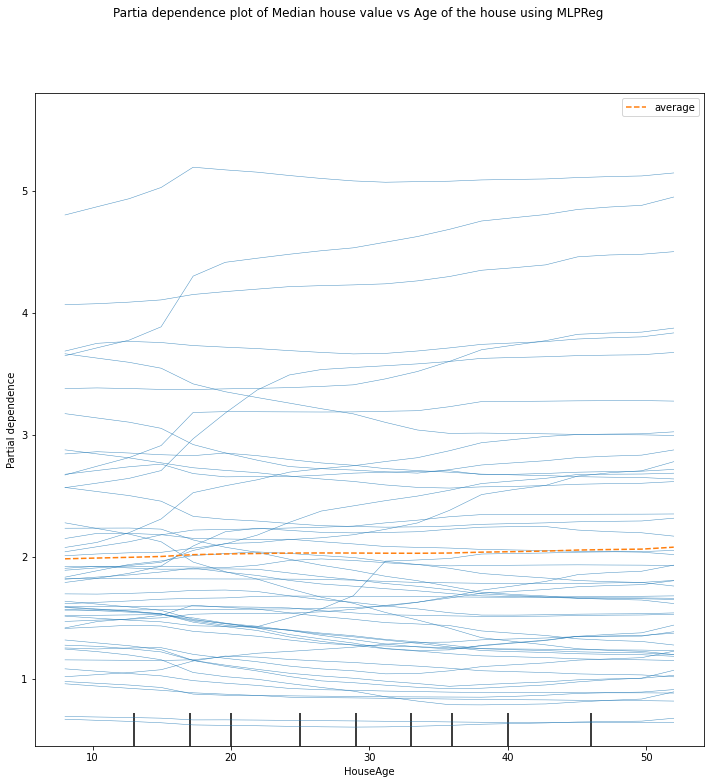

In [38]:
plt.rcParams["figure.figsize"]=12,12
from sklearn.inspection import PartialDependenceDisplay
pdp = PartialDependenceDisplay.from_estimator(
    model,
    x_train,
    ["HouseAge"],
    kind = 'both',
    subsample = 50,
    n_jobs = 3,
    grid_resolution = 20,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.8, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"})
pdp.figure_.suptitle("Partia dependence plot of Median house value vs Age of the house using MLPReg")
pdp.figure_.subplots_adjust(hspace = 0.2)



**iii)** What do these plots tell us? Can they indicate the importance of the feature and if not, how do you get it?

**Solution:**

From the first plot, we observes an unexpected behavior where the median house value is increasing with the age. From the second plot the marginal effect of house-age to the median value of the house is insignificant on the average. (The plot is flat on the average). In this manner the two plots cannot reflect the importance of the feature. This might be due strong correlation of house-age and other features. To fix this we may need to compute accumulated local effects plot (ALE) which takes care of interaction effect. 

# 2) Accumulated Local Effects (ALE) Plots

## a) Theory


**i)** What is there problem with PDPs and why can't we blindly trust PDP-based Feature Importance?

**Solution:**

PDP's cannot handle correlation structure in the dataset. When the features are correlated PDP's may be flat to signifying that the variable has no marginal impact on the prediction but this is not always the case. 
PDP's also operate under strong assumption of indepence of features and cannot handle heterogeneous effect. We cannot blindly trust PDP-based feature's importance because its capture only the main effect of the feature and any form of correlation stracture is ignored.

**ii)** Explain the concepts of PDP, M-Plots and ALE plots and their differences. What are the respective advantages and disadvantages of each method compared to the other two?

**Solution:**

PDP: This a global procedure that determine the averange change on the prediction for the marginal changes on the respective feature(s). Compared to M-Plots and ALE-plots, this method cannot handle correlation structure in the data but it can perfectly describe the situation when the features are independent. The interpretation of PDP is intuitively easier, simple to impement and can show causality in some cases.  
The M-plots apply the conditional distribution of the features to obtain the average prediction. This method averaging the local predictions which leads to the mix effect of both correlated features. This becomes unrealistic when only one feature is important. Compared to PDP, M-plots avoid the averaging of unlikely data instances.
ALE plots is the method that applies conditional distribution of the features to obtain the diffence in prediction. This method overcome the disadvantage of M-plots technique by avoid mixing the effect of a feature with the other correlated features. Compared to PDP and M-plots, ALE plots yield the diffence in prediction based on pure effect of a feature conditioned on other correlated features.

# b) Example: ALE Plot

**i)** Install the package [ALEPython](https://github.com/blent-ai/ALEPython) from Github and create an ALE plot for the example from task **1)** as well for the feature `HouseAge`.

**Hint:** See the 'Install' and 'Usage' section on the Github page.

**Solution:**

In [39]:
# Install package
#!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython


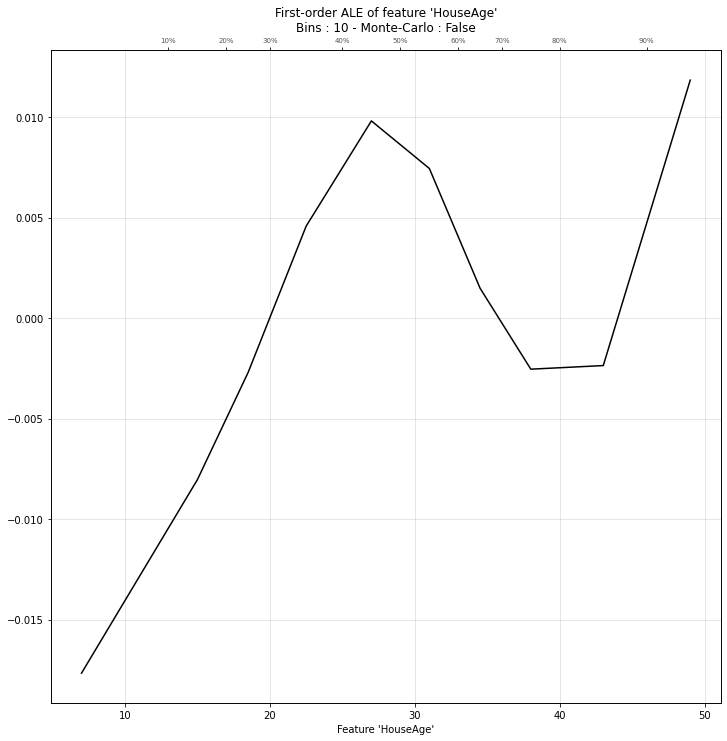

In [40]:
# Create the ALE plot (set 'monte_carlo = False')

from alepython import ale_plot
ale_plot(model = model, train_set = x_train, features = ["HouseAge"], monte_carlo = False)

**II)** How does the ALE plot differ from the PDP in task 1? Give possible reasons for the similarities or differences.

**Solution:**

The above ALE plot resembles the PDP which was manually implemented probably because that procedure literally compute the prediction based on the main effect of the feature (There was no interaction effect i.e, only one variable was considered). For the case of PDP obtained using the PartialDependenceDisplay method, the ALE plot significantly differs from it. This is because ALE plot take care of correlation structure. The ALE plot present the diffence in prediction based on the respective feature conditioned on other correlated features.